In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import datetime
import joblib
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras import metrics as keras_metrics


<p style='font-size:18px'><b> 1) Level 3 Model </b></p>
<p style='font-size:16px'><b> 1.1 Objective </b></p>

<p>

- As seen in L3a_EDA, we are left with points forming the overlap which will be separated by the final decision boundary in this level.
- Here, we will build the final model that outputs the final points that we believe to be fraud.
    
</p>

<p style='font-size:16px'><b> 1.2 Model charecteristics </b></p>

<p>

Here too, we will use neural networks because capturing complex decision boundaries is the highest priority.
    
</p>


In [2]:
# Load the dataset for credit card frauds
train_data = pd.read_csv('dataset/creditcard_train_l3.csv')

In [3]:
def prob_class(y_proba, y_actual, num_buckets):
    
    prob_buckets = np.linspace(0,1,num_buckets+1)
    prob_class_report = []
    prob_class_report.append(['Prob range', 'Not-Fraud', 'Fraud'])
    
    for i in range(len(prob_buckets)-1):
        
        # Col1: Probability range
        prob_range = '(' + str(round(prob_buckets[i],2)) + ', ' + str(round(prob_buckets[i+1],2)) + ']'
        
        # Defining the upper and lower bound of the probability
        prob_high = prob_buckets[i+1]
        if i==0:
            prob_low = -0.01
        else:
            prob_low = prob_buckets[i]
        
        # Col2: #Points that are not fraud in the prob_range
        not_fraud = np.sum((y_proba>prob_low)&(y_proba<=prob_high)&(y_actual==0))

        # Col3: #Points that are fraud in the prob_range
        fraud = np.sum((y_proba>prob_low)&(y_proba<=prob_high)&(y_actual==1))
        
        prob_class_report.append([prob_range, not_fraud, fraud])
    
    # Printing the Prob range vs count of fraud or not-fraud points
    print("\nDistribution of class labels for various prob buckets: \n")
    col_width = 15
    print("".join(word.center(col_width) for word in prob_class_report[0]))
    print("----------------------------------------------------")
    for row in prob_class_report[1:]:
        print(str(row[0]).center(col_width), end = "")
        print(str(row[1]).center(col_width), end = "")
        print(str(row[2]).center(col_width))
    
    # Prob value of the fraud datapoint having lowest prob value
    fraud_min_prob = np.min(y_proba[(y_actual==1)])
    
    # Number of not fraud datapoints having prob value below the fraud_min_prob
    not_fraud_1 = np.sum((y_actual==0)&(y_proba<fraud_min_prob))

    # Number of not fraud datapoints having prob value below the 90% of fraud_min_prob
    not_fraud_2 = np.sum((y_actual==0)&(y_proba<0.9*fraud_min_prob))
    
    # Number of not fraud datapoints having prob value below the 90% of fraud_min_prob
    not_fraud_3 = np.sum((y_actual==0)&(y_proba<0.5*fraud_min_prob))
    
    print("\n1. Lowest prob value in the fraud class (threshold): {}%".format(round(100*fraud_min_prob,3)))
    print("2. # of not fraud pts below threshold: {}".format(not_fraud_1))
    print("3. # of not fraud pts below 90% of threshold: {}".format(not_fraud_2))
    print("4. # of not fraud pts below 50% of threshold: {}".format(not_fraud_3))
    
    return (fraud_min_prob, not_fraud_1, not_fraud_2, not_fraud_3)
    

In [4]:
def plt_training_history(history):
    
    fig = plt.figure(figsize = (15,4))
    fig.subplots_adjust(wspace = 0.3)
    axs = fig.subplots(1, 3)
    
    # Plot the training & test loss vs epoch
    train_loss = history.history['loss']
#     val_loss = history.history['val_loss']
    epochs = np.arange(1, len(train_loss)+1, 1)
    
    axs[0].plot(epochs,train_loss,label = 'Train loss', color='b', linewidth=2)
#     axs[0].plot(epochs,val_loss,label = 'Val loss', color='r', linewidth=2)
    axs[0].set(xlabel = 'epoch #', ylabel = 'Loss value', title = 'Train & Val loss vs epochs')
    axs[0].legend()
    
    # Plot the training & test accuracy vs epoch
    train_acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
    
    axs[1].plot(epochs,train_acc,label = 'Train accuracy', color='b', linewidth=2)
#     axs[1].plot(epochs,val_acc,label = 'Val accuracy', color='r', linewidth=2)
    axs[1].set(xlabel = 'epoch #', ylabel = 'Accuracy value', title = 'Train & Val accuracy vs epochs')
    axs[1].legend()

    # Plot the training & test recall vs epoch
    train_rec = history.history['recall']
#     val_rec = history.history['val_recall']
    
    axs[2].plot(epochs,train_rec,label = 'Train recall', color='b', linewidth=2)
#     axs[2].plot(epochs,val_rec,label = 'Val recall', color='r', linewidth=2)
    axs[2].set(xlabel = 'epoch #', ylabel = 'Recall value', title = 'Train & Val recall vs epochs')
    axs[2].legend()

In [5]:
# Split into X (input) & Y (output)
train_x = train_data.drop(['Time', 'Class'], axis = 1).to_numpy()
train_y = train_data['Class'].to_numpy()

In [6]:
# Standardizing the data - necessary for Neural network
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)

In [7]:
# Level 2: Neural network with dropout

# Defining model parameters
input_dim = train_x_scaled.shape[1]
layer_1 = 512
layer_2 = 128
output_dim = 1

# Defining training parameters
batch_size = 200
num_epoch = 50

# Defining the model architecture using Keras
nn_model = Sequential()
nn_model.add(Dense(units = layer_1, activation='relu', input_shape = (input_dim, )))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(units = layer_2, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(units = output_dim, activation='sigmoid'))
nn_model.summary()

# Defining the training parameters of the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras_metrics.Recall(name = 'recall')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15872     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 81,665
Trainable params: 81,665
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fitting the model & logging the train, test loss & metrics of each epoch in history
# Batch size: needs to be specifed here?? ELse steps_per_epoch won't match?

start_time = datetime.datetime.now()

history = nn_model.fit(train_x_scaled, train_y, batch_size=batch_size, epochs=num_epoch, verbose=2) 

print("Training time: ", datetime.datetime.now() - start_time)

Epoch 1/50
12/12 - 1s - loss: 0.3941 - accuracy: 0.8769 - recall: 0.6756 - 720ms/epoch - 60ms/step
Epoch 2/50
12/12 - 0s - loss: 0.2161 - accuracy: 0.9417 - recall: 0.7399 - 51ms/epoch - 4ms/step
Epoch 3/50
12/12 - 0s - loss: 0.1815 - accuracy: 0.9434 - recall: 0.7721 - 52ms/epoch - 4ms/step
Epoch 4/50
12/12 - 0s - loss: 0.1709 - accuracy: 0.9476 - recall: 0.8123 - 52ms/epoch - 4ms/step
Epoch 5/50
12/12 - 0s - loss: 0.1611 - accuracy: 0.9506 - recall: 0.8150 - 50ms/epoch - 4ms/step
Epoch 6/50
12/12 - 0s - loss: 0.1506 - accuracy: 0.9566 - recall: 0.8043 - 48ms/epoch - 4ms/step
Epoch 7/50
12/12 - 0s - loss: 0.1477 - accuracy: 0.9553 - recall: 0.8311 - 55ms/epoch - 5ms/step
Epoch 8/50
12/12 - 0s - loss: 0.1392 - accuracy: 0.9608 - recall: 0.8150 - 53ms/epoch - 4ms/step
Epoch 9/50
12/12 - 0s - loss: 0.1396 - accuracy: 0.9574 - recall: 0.8284 - 48ms/epoch - 4ms/step
Epoch 10/50
12/12 - 0s - loss: 0.1386 - accuracy: 0.9608 - recall: 0.8284 - 49ms/epoch - 4ms/step
Epoch 11/50
12/12 - 0s - lo

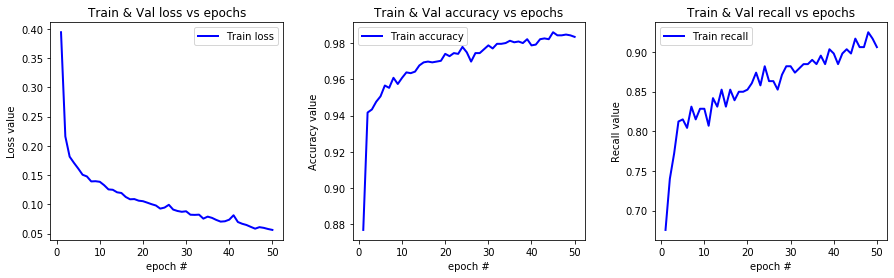

In [9]:
# Visualize progression of train, val loss vs epochs

plt_training_history(history)

In [11]:
# Probability vs class labels
y_pred_proba_train = nn_model.predict(train_x_scaled).flatten()
prob_details = prob_class(y_pred_proba_train, train_y, 20)

# Filter the points that we are not confident to be not-fraud
prob_thresh = prob_details[0]*0.75
print("\nProb threshold selected: {}%".format(round(100*prob_thresh,2)))
temp = train_data[(y_pred_proba_train>=prob_thresh)]
print("Number of points classified as fraud: ", temp.shape[0])

l3_prob_thresh = prob_thresh

74/74 [==============================] - 0s 1ms/step

Distribution of class labels for various prob buckets: 

   Prob range     Not-Fraud        Fraud     
----------------------------------------------------
  (0.0, 0.05]        1796            7       
  (0.05, 0.1]        101             6       
  (0.1, 0.15]         43             3       
  (0.15, 0.2]         17             1       
  (0.2, 0.25]         5              2       
  (0.25, 0.3]         5              0       
  (0.3, 0.35]         5              2       
  (0.35, 0.4]         2              1       
  (0.4, 0.45]         0              0       
  (0.45, 0.5]         1              3       
  (0.5, 0.55]         0              1       
  (0.55, 0.6]         0              5       
  (0.6, 0.65]         0              3       
  (0.65, 0.7]         0              2       
  (0.7, 0.75]         0              6       
  (0.75, 0.8]         0              6       
  (0.8, 0.85]         0              7       
  (0.85,

In [12]:
joblib.dump(scaler, 'models/l3_scaler.pkl')
joblib.dump(nn_model, 'models/l3_nnmodel_clf.pkl')
joblib.dump(l3_prob_thresh, 'models/l3_prob_thresh.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-06-30 20:51:52         2299
metadata.json                                  2024-06-30 20:51:52           64
variables.h5                                   2024-06-30 20:51:52      1008808


['models/l3_prob_thresh.pkl']